# Generate plots for figure 3

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from definitions import ROOT_DIR
from helpers import get_pos_vel_act, get_exp_var_ratio, get_dof_count, plot_explained_variance_ratio

## Load the dataset Baoding-SV and Control

In [4]:
baoding_df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "datasets", "rollouts", "baoding_sv_no_activity.h5"))
control_df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "datasets", "rollouts", "hand_pose.h5"))

pos_control, vel_control, muscle_act_control = get_pos_vel_act(control_df)
pos_baoding, vel_baoding, muscle_act_baoding = get_pos_vel_act(baoding_df)

## Compute the pca of the joint angles, joint position and joint velocities and measure the dimensionality

In [5]:
# PCA of the hand poses for the Control (Hand Pose) and for the task (baoding)
num_joints = 23 
num_muscles = 39 

exp_var_pos_control = get_exp_var_ratio(data=pos_control, n_comp=num_joints)
exp_var_pos_baoding = get_exp_var_ratio(data=pos_baoding, n_comp=num_joints)

exp_var_vel_control = get_exp_var_ratio(data=vel_control, n_comp=num_joints)
exp_var_vel_baoding = get_exp_var_ratio(data=vel_baoding, n_comp=num_joints)

exp_var_muscle_control = get_exp_var_ratio(data=muscle_act_control, n_comp=num_muscles)
exp_var_muscle_baoding = get_exp_var_ratio(data=muscle_act_baoding, n_comp=num_muscles)

exp_var_dict = {
    "pos": {
        "control": exp_var_pos_control,
        "baoding": exp_var_pos_baoding
    },
    "vel": {
        "control": exp_var_vel_control,
        "baoding": exp_var_vel_baoding
    },
    "muscle_act": {
        "control": exp_var_muscle_control,
        "baoding": exp_var_muscle_baoding
    }
}

In [6]:
levels = [0.85, 0.95]
dof_count_dict = {}
for data_type, task_var_dict in exp_var_dict.items():
    dof_per_task_dict = {}
    for task, exp_var in task_var_dict.items():
        dof_per_level_dict = {}
        for l in levels:
            dof_count = get_dof_count(exp_var, l)
            dof_per_level_dict[l] = dof_count
        dof_per_level_dict["avg"] = np.mean(list(dof_per_level_dict.values()))
        dof_per_task_dict[task] = dof_per_level_dict
    dof_count_dict[data_type] = dof_per_task_dict

print(json.dumps(dof_count_dict, indent=4))

{
    "pos": {
        "control": {
            "0.85": 6,
            "0.95": 10,
            "avg": 8.0
        },
        "baoding": {
            "0.85": 4,
            "0.95": 7,
            "avg": 5.5
        }
    },
    "vel": {
        "control": {
            "0.85": 4,
            "0.95": 7,
            "avg": 5.5
        },
        "baoding": {
            "0.85": 6,
            "0.95": 11,
            "avg": 8.5
        }
    },
    "muscle_act": {
        "control": {
            "0.85": 5,
            "0.95": 9,
            "avg": 7.0
        },
        "baoding": {
            "0.85": 9,
            "0.95": 15,
            "avg": 12.0
        }
    }
}


In [7]:
# Extracted from Todorov's paper 
experimental_dof = {
    "pos": {
        "control": {
            "0.85": 7,
            "0.95": 10,
            "avg": 8.5
        },
        "baoding": {
            "0.85": 3,
            "0.95": 7,
            "avg": 5
        }
    },
    "vel": {
        "control": {
            "0.85": 8,
            "0.95": 12,
            "avg": 10
        },
        "baoding": {
            "0.85": 4,
            "0.95": 8,
            "avg": 6
        }
    }
}

## Compare the explained variance of Baoding and Control

In [8]:
# create figure directory if it doesn't already exist
out_path = os.path.join(ROOT_DIR, "data", "figures", "fig_3")
os.makedirs(out_path, exist_ok=True)

/tmp/ipykernel_51518/1533897416.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_51518/1533897416.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


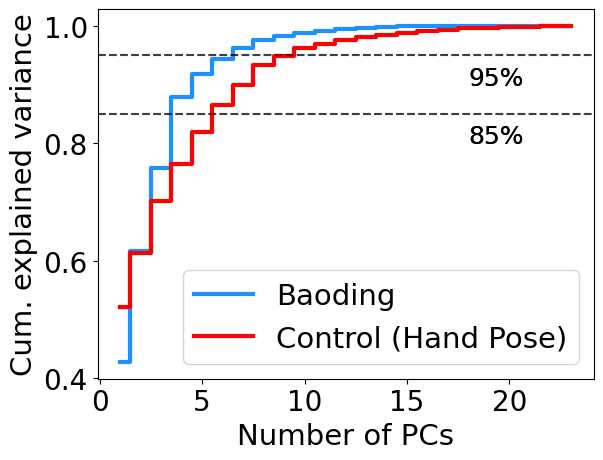

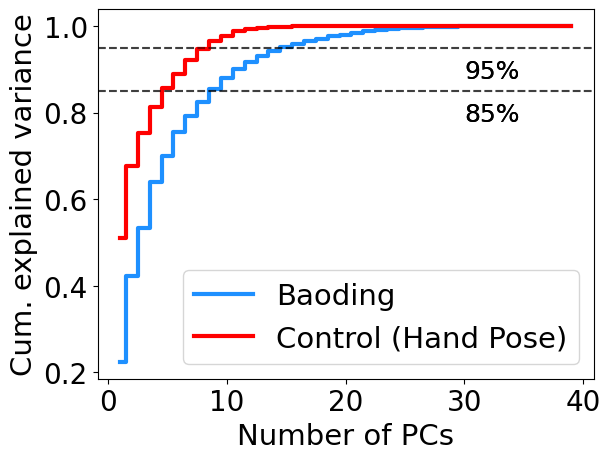

In [9]:
fig, ax = plot_explained_variance_ratio(np.cumsum(exp_var_pos_baoding), "baoding", "dodgerblue", xtext_pos=(18, 0.9), ytext_pos=(18, 0.8), label="Baoding")
plot_explained_variance_ratio(np.cumsum(exp_var_pos_control), "hand_pose", "red", ax=ax, fig=fig, xtext_pos=(18, 0.9), ytext_pos=(18, 0.8), label="Control (Hand Pose)")
ax.legend(fontsize=21,loc='best')
fig.savefig(os.path.join(out_path, "pca_pos.png"), format="png", dpi=600, bbox_inches="tight")
fig.show()

fig, ax = plot_explained_variance_ratio(np.cumsum(exp_var_muscle_baoding), "baoding", "dodgerblue", xtext_pos=(30, 0.88), ytext_pos=(30, 0.78), label="Baoding")
plot_explained_variance_ratio(np.cumsum(exp_var_muscle_control), "hand_pose", "red", ax=ax, fig=fig, xtext_pos=(30, 0.88), ytext_pos=(30, 0.78), label="Control (Hand Pose)")
ax.legend(fontsize=21,loc='best')
fig.savefig(os.path.join(out_path, "pca_muscle_act.png"), format="png", dpi=600, bbox_inches="tight")
fig.show()

## Barplot of the explained variance - Todorov vs our experiments

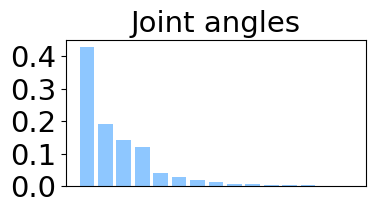

In [10]:
n_comp=15
exp_var_ratio=exp_var_pos_baoding[:15]
title='Joint angles'
plt.figure(figsize=(4, 2))
plt.bar(range(1,n_comp+1), exp_var_ratio, alpha=0.5, align='center',label='Individual variance', color="dodgerblue")
plt.title(title,fontsize=21)
plt.yticks(fontsize=21)
plt.xticks([])
plt.subplots_adjust(left=0.15,bottom=0.15)
plt.savefig(os.path.join(out_path, "cum_var_barplot_sds.png"), format="png", dpi=800, bbox_inches="tight")


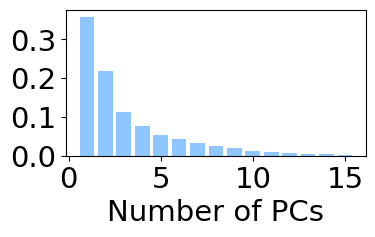

In [11]:
# Values extracted from the graph of Todorov's paper with an online extraction tool
exp_var_ratio_todorov = np.array([35.88, 21.80, 11.31, 7.60, 5.24, 4.21, 3.29, 2.47, 2.06, 1.34, 0.92, 0.72, 0.51, 0.41, 0.30]) * 1e-2
n_comp=15
exp_var_ratio=exp_var_ratio_todorov

plt.figure(figsize=(4, 2))
plt.bar(range(1,n_comp+1), exp_var_ratio, alpha=0.5, align='center',label='Individual variance', color="dodgerblue")
plt.xlabel('Number of PCs',fontsize=21)
plt.yticks(fontsize=21)
plt.xticks([0, 5, 10, 15], fontsize=21)
plt.subplots_adjust(left=0.15,bottom=0.15)
plt.savefig(os.path.join(out_path, "cum_var_barplot_human.png"), format="png", dpi=800, bbox_inches="tight")
